# BM25 vs DeepCT+Conv-KNRM Comparison

## 📊 Overview
So sánh hiệu suất giữa 2 phương pháp ranking:
1. **BM25** - Traditional probabilistic retrieval (baseline)
2. **DeepCT + Conv-KNRM** - Deep learning neural ranking

### 🎯 Evaluation Metrics:
- **Search Time** - Thời gian tìm kiếm
- **Relevance Scores** - Điểm relevance của top results
- **Ranking Quality** - Chất lượng ranking (manual evaluation)

### 📝 Test Queries:
- "Quang Hải"
- "HLV Park Hang-seo"
- "đội tuyển Việt Nam"
- "V-League 2024"
- "World Cup"

## 1. Import Libraries & Load Data

In [15]:
import os
import json
import re
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict
import pickle
import math

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Vietnamese text processing
try:
    from pyvi import ViTokenizer
    PYVI_AVAILABLE = True
    print("✓ PyVi available")
except ImportError:
    print("✗ PyVi not available")
    PYVI_AVAILABLE = False

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ PyVi available
PyTorch version: 2.3.1+cpu
Device: cpu


## 2. Vietnamese Text Processor (Shared)

In [16]:
class VietnameseTextProcessor:
    """Vietnamese text processing for both BM25 and Neural models"""
    
    def __init__(self):
        self.stop_words = set([
            'và', 'của', 'trong', 'với', 'là', 'có', 'được', 'cho', 'từ', 'một', 'các',
            'để', 'không', 'sẽ', 'đã', 'về', 'hay', 'theo', 'như', 'cũng', 'này', 'đó',
            'khi', 'những', 'tại', 'sau', 'bị', 'giữa', 'trên', 'dưới', 'ngoài',
            'thì', 'nhưng', 'mà', 'hoặc', 'nếu', 'vì', 'do', 'nên', 'rồi', 'còn', 'đều',
            'chỉ', 'việc', 'người', 'lại', 'đây', 'đấy', 'ở', 'ra', 'vào', 'lên', 'xuống'
        ])
    
    def clean_text(self, text):
        if not text:
            return ""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\sàáảãạăắằẳẵặâấầẩẫậèéẻẽẹêếềểễệìíỉĩịòóỏõọôốồổỗộơớờởỡợùúủũụưứừửữựỳýỷỹỵđĐ]', ' ', text)
        text = text.lower()
        return re.sub(r'\s+', ' ', text).strip()
    
    def tokenize(self, text):
        if PYVI_AVAILABLE:
            try:
                return ViTokenizer.tokenize(text).split()
            except:
                pass
        return text.split()
    
    def remove_stopwords(self, tokens):
        return [token for token in tokens if token not in self.stop_words and len(token) > 1]
    
    def preprocess(self, text, remove_stop=True):
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        if remove_stop:
            tokens = self.remove_stopwords(tokens)
        return tokens

processor = VietnameseTextProcessor()
print("✓ VietnameseTextProcessor initialized")

✓ VietnameseTextProcessor initialized


## 3. Load Documents

In [17]:
def load_documents(json_files=None):
    if json_files is None:
        json_files = [
            "vnexpressT_bongda_part1.json",
            "vnexpressT_bongda_part2.json",
            "vnexpressT_bongda_part3.json",
            "vnexpressT_bongda_part4.json"
        ]
    
    documents = []
    print("📥 Loading documents...")
    
    for file_path in json_files:
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    documents.extend(data)
                print(f"  ✓ Loaded {file_path}: {len(data)} docs")
    
    print(f"\n✓ Total documents: {len(documents)}")
    return documents

documents = load_documents()
print(f"\n📄 Sample: {documents[0]['title'][:80]}...")

📥 Loading documents...
  ✓ Loaded vnexpressT_bongda_part1.json: 473 docs
  ✓ Loaded vnexpressT_bongda_part2.json: 488 docs
  ✓ Loaded vnexpressT_bongda_part3.json: 487 docs
  ✓ Loaded vnexpressT_bongda_part4.json: 308 docs

✓ Total documents: 1756

📄 Sample: 'Ảo tưởng bóng đá Việt Nam vươn tầm khi giành vé dự VCK U23 châu Á'...


## 4. BM25 Implementation

In [18]:
class BM25:
    """BM25 ranking algorithm"""
    
    def __init__(self, documents, processor, k1=1.5, b=0.75):
        self.documents = documents
        self.processor = processor
        self.k1 = k1
        self.b = b
        
        print("\n🔨 Building BM25 index...")
        self.doc_tokens = []
        self.doc_lengths = []
        self.df = Counter()
        
        # Process documents
        for doc in tqdm(documents, desc="Indexing"):
            title = doc.get('title', '')
            content = doc.get('content', '')
            full_text = f"{title} {content}"
            tokens = processor.preprocess(full_text)
            
            self.doc_tokens.append(tokens)
            self.doc_lengths.append(len(tokens))
            
            # Document frequency
            for token in set(tokens):
                self.df[token] += 1
        
        self.N = len(documents)
        self.avgdl = sum(self.doc_lengths) / self.N
        
        print(f"✓ Indexed {self.N} documents")
        print(f"  - Avg doc length: {self.avgdl:.1f} tokens")
        print(f"  - Vocabulary size: {len(self.df)}")
    
    def idf(self, term):
        """Inverse document frequency"""
        df = self.df.get(term, 0)
        return math.log((self.N - df + 0.5) / (df + 0.5) + 1)
    
    def score(self, query_tokens, doc_idx):
        """BM25 score for a document"""
        doc_tokens = self.doc_tokens[doc_idx]
        doc_len = self.doc_lengths[doc_idx]
        
        score = 0.0
        doc_freq = Counter(doc_tokens)
        
        for term in query_tokens:
            if term not in doc_freq:
                continue
            
            tf = doc_freq[term]
            idf = self.idf(term)
            
            # BM25 formula
            numerator = tf * (self.k1 + 1)
            denominator = tf + self.k1 * (1 - self.b + self.b * (doc_len / self.avgdl))
            
            score += idf * (numerator / denominator)
        
        return score
    
    def search(self, query, top_k=10):
        """Search and rank documents"""
        query_tokens = self.processor.preprocess(query)
        
        # Score all documents
        scores = []
        for idx in range(self.N):
            score = self.score(query_tokens, idx)
            if score > 0:
                scores.append((idx, score))
        
        # Sort by score
        scores.sort(key=lambda x: x[1], reverse=True)
        
        # Return top-k
        results = []
        for idx, score in scores[:top_k]:
            results.append({
                'doc_index': idx,
                'score': float(score),
                'document': self.documents[idx]
            })
        
        return results

# Initialize BM25
bm25_engine = BM25(documents, processor)
print("\n✅ BM25 engine ready!")


🔨 Building BM25 index...


Indexing: 100%|██████████| 1756/1756 [00:19<00:00, 91.41it/s] 


✓ Indexed 1756 documents
  - Avg doc length: 424.8 tokens
  - Vocabulary size: 15607

✅ BM25 engine ready!


## 5. Load DeepCT + Conv-KNRM Models

In [19]:
# Import model classes from DeepCT_ConvKRM.ipynb
# (You need to copy the model definitions here or load from saved file)

class DeepCT(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, dropout=0.3, max_weight=100):
        super(DeepCT, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.max_weight = max_weight
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, bidirectional=True, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, doc_indices):
        embedded = self.embedding(doc_indices)
        lstm_out, _ = self.lstm(embedded)
        term_weights = self.fc(lstm_out).squeeze(-1)
        term_weights = torch.clamp(F.relu(term_weights), min=0, max=self.max_weight)
        return term_weights

class ConvKNRM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, n_kernels=11, conv_filters=[1, 2, 3], embedding_layer=None):
        super(ConvKNRM, self).__init__()
        if embedding_layer is not None:
            self.embedding = embedding_layer
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, embedding_dim, kernel_size=k, padding=(k-1)//2)
            for k in conv_filters
        ])
        
        self.n_kernels = n_kernels
        self.kernel_mus = nn.Parameter(torch.linspace(-1, 1, n_kernels), requires_grad=False)
        self.kernel_sigmas = nn.Parameter(torch.full((n_kernels,), 0.1), requires_grad=False)
        
        self.fc = nn.Sequential(
            nn.Linear(n_kernels * len(conv_filters), 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def kernel_pooling(self, similarity_matrix):
        sim_expanded = similarity_matrix.unsqueeze(-1)
        kernel_values = torch.exp(-((sim_expanded - self.kernel_mus) ** 2) / (2 * self.kernel_sigmas ** 2))
        K = torch.sum(kernel_values, dim=2)
        pooled = torch.sum(torch.log(K + 1e-10), dim=1)
        return pooled
    
    def forward(self, query_indices, doc_indices, doc_weights=None):
        query_embed = self.embedding(query_indices)
        doc_embed = self.embedding(doc_indices)
        
        if doc_weights is not None:
            doc_weights_norm = doc_weights / (doc_weights.sum(dim=1, keepdim=True) + 1e-10) * doc_weights.size(1)
            doc_embed = doc_embed * doc_weights_norm.unsqueeze(-1)
        
        all_features = []
        for conv in self.convs:
            query_conv = conv(query_embed.transpose(1, 2)).transpose(1, 2)
            doc_conv = conv(doc_embed.transpose(1, 2)).transpose(1, 2)
            query_norm = F.normalize(query_conv, p=2, dim=-1)
            doc_norm = F.normalize(doc_conv, p=2, dim=-1)
            similarity = torch.bmm(query_norm, doc_norm.transpose(1, 2))
            pooled = self.kernel_pooling(similarity)
            all_features.append(pooled)
        
        features = torch.cat(all_features, dim=-1)
        scores = self.fc(features)
        return scores

class DeepCT_ConvKNRM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, n_kernels=11, conv_filters=[1, 2, 3], use_deepct=True, max_weight=100):
        super(DeepCT_ConvKNRM, self).__init__()
        self.use_deepct = use_deepct
        self.shared_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if use_deepct:
            self.deepct = DeepCT(vocab_size, embedding_dim, hidden_dim, max_weight=max_weight)
            self.deepct.embedding = self.shared_embedding
        
        self.convknrm = ConvKNRM(vocab_size, embedding_dim, n_kernels, conv_filters, embedding_layer=self.shared_embedding)
    
    def forward(self, query_indices, doc_indices):
        doc_weights = None
        if self.use_deepct:
            doc_weights = self.deepct(doc_indices)
        scores = self.convknrm(query_indices, doc_indices, doc_weights)
        return scores, doc_weights

print("✓ Model classes defined")

✓ Model classes defined


## 6. Load Vocabulary & Trained Model

In [20]:
# Build vocabulary (same as training)
class Vocabulary:
    def __init__(self, min_freq=2):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freq = Counter()
        self.min_freq = min_freq
    
    def build_vocab(self, documents, processor):
        print("\n🏗️ Building vocabulary...")
        for doc in tqdm(documents, desc="Counting words"):
            title = doc.get('title', '')
            content = doc.get('content', '')
            tokens = processor.preprocess(f"{title} {content}")
            self.word_freq.update(tokens)
        
        idx = 2
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"✓ Vocabulary: {len(self.word2idx)} words")
        return self
    
    def encode(self, tokens, max_len=None):
        indices = [self.word2idx.get(token, 1) for token in tokens]
        if max_len:
            if len(indices) < max_len:
                indices += [0] * (max_len - len(indices))
            else:
                indices = indices[:max_len]
        return indices

vocab = Vocabulary(min_freq=2)
vocab.build_vocab(documents, processor)
vocab_size = len(vocab.word2idx)

# Load trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n⚡ Loading trained model on {device}...")

neural_model = DeepCT_ConvKNRM(
    vocab_size=vocab_size,
    embedding_dim=100,
    hidden_dim=128,
    n_kernels=11,
    conv_filters=[1, 2, 3],
    use_deepct=True
)

# Load weights
if os.path.exists('deepct_convknrm_vi.pth'):
    neural_model.load_state_dict(torch.load('deepct_convknrm_vi.pth', map_location=device))
    print("✓ Loaded trained weights from deepct_convknrm_vi.pth")
else:
    print("⚠️  Model file not found! Using untrained model.")

neural_model = neural_model.to(device)
neural_model.eval()

print(f"\n✅ Neural model ready! ({sum(p.numel() for p in neural_model.parameters()):,} parameters)")


🏗️ Building vocabulary...


Counting words: 100%|██████████| 1756/1756 [00:19<00:00, 89.67it/s] 


✓ Vocabulary: 10369 words

⚡ Loading trained model on cpu...
✓ Loaded trained weights from deepct_convknrm_vi.pth

✅ Neural model ready! (1,763,272 parameters)


## 7. Pre-encode Documents for Neural Model

In [21]:
print("\n📦 Pre-encoding all documents for neural model...")

all_doc_tensors = []
for doc in tqdm(documents, desc="Encoding"):
    title = doc.get('title', '')
    content = doc.get('content', '')
    full_text = f"{title} {content}"
    doc_tokens = processor.preprocess(full_text)
    doc_indices = vocab.encode(doc_tokens, max_len=200)
    all_doc_tensors.append(torch.LongTensor(doc_indices))

doc_batch_tensor = torch.stack(all_doc_tensors).to(device)
print(f"✓ Pre-encoded documents: {doc_batch_tensor.shape}")
print("✅ Neural search ready!")


📦 Pre-encoding all documents for neural model...


Encoding: 100%|██████████| 1756/1756 [00:22<00:00, 79.05it/s] 

✓ Pre-encoded documents: torch.Size([1756, 200])
✅ Neural search ready!


## 8. Define Search Functions

In [22]:
def neural_search(query_text, top_k=10, batch_size=256):
    """Neural search with DeepCT + Conv-KNRM"""
    start_time = time.time()
    
    # Encode query
    query_tokens = processor.preprocess(query_text)
    query_indices = vocab.encode(query_tokens, max_len=20)
    query_tensor = torch.LongTensor(query_indices).unsqueeze(0).to(device)
    
    all_scores = []
    
    with torch.no_grad():
        num_docs = len(documents)
        num_batches = (num_docs + batch_size - 1) // batch_size
        
        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, num_docs)
            
            doc_batch = doc_batch_tensor[start:end]
            batch_len = doc_batch.size(0)
            query_batch = query_tensor.expand(batch_len, -1)
            
            scores, _ = neural_model(query_batch, doc_batch)
            scores = torch.sigmoid(scores).squeeze(-1).cpu().numpy()
            all_scores.extend(scores)
    
    # Create results
    results = [(i, float(score), documents[i]) for i, score in enumerate(all_scores)]
    results.sort(key=lambda x: x[1], reverse=True)
    
    search_time = time.time() - start_time
    
    return results[:top_k], search_time


def bm25_search(query_text, top_k=10):
    """BM25 search"""
    start_time = time.time()
    results = bm25_engine.search(query_text, top_k=top_k)
    search_time = time.time() - start_time
    
    # Format to match neural results
    formatted = [
        (r['doc_index'], r['score'], r['document']) 
        for r in results
    ]
    
    return formatted, search_time

print("✓ Search functions defined")

✓ Search functions defined


## 9. Comparison Function

In [23]:
def compare_search_results(query, top_k=5):
    """Compare BM25 vs Neural search"""
    
    print("\n" + "="*100)
    print(f"🔍 QUERY: '{query}'")
    print("="*100)
    
    # BM25 Search
    print("\n📊 BM25 (Baseline)")
    print("-" * 100)
    bm25_results, bm25_time = bm25_search(query, top_k=top_k)
    print(f"⏱️  Search time: {bm25_time:.4f}s")
    print(f"\nTop {top_k} Results:")
    for rank, (idx, score, doc) in enumerate(bm25_results, 1):
        title = doc['title'][:70]
        print(f"  [{rank}] Score: {score:8.4f} | {title}...")
    
    # Neural Search
    print("\n🧠 DeepCT + Conv-KNRM (Neural)")
    print("-" * 100)
    neural_results, neural_time = neural_search(query, top_k=top_k)
    print(f"⏱️  Search time: {neural_time:.4f}s")
    print(f"\nTop {top_k} Results:")
    for rank, (idx, score, doc) in enumerate(neural_results, 1):
        title = doc['title'][:70]
        print(f"  [{rank}] Score: {score:8.4f} | {title}...")
    
    # Comparison Summary
    print("\n" + "="*100)
    print("📈 COMPARISON SUMMARY")
    print("="*100)
    print(f"⏱️  Speed:")
    print(f"   - BM25: {bm25_time:.4f}s")
    print(f"   - Neural: {neural_time:.4f}s")
    print(f"   - Speedup: {bm25_time/neural_time:.2f}x {'faster' if bm25_time < neural_time else 'slower'}")
    
    print(f"\n🎯 Score Ranges:")
    bm25_scores = [score for _, score, _ in bm25_results]
    neural_scores = [score for _, score, _ in neural_results]
    print(f"   - BM25: [{min(bm25_scores):.4f}, {max(bm25_scores):.4f}]")
    print(f"   - Neural: [{min(neural_scores):.4f}, {max(neural_scores):.4f}]")
    
    print(f"\n🔄 Overlap (same docs in top-{top_k}):")
    bm25_doc_ids = {idx for idx, _, _ in bm25_results}
    neural_doc_ids = {idx for idx, _, _ in neural_results}
    overlap = len(bm25_doc_ids & neural_doc_ids)
    print(f"   - {overlap}/{top_k} documents ({100*overlap/top_k:.1f}%)")
    
    return {
        'query': query,
        'bm25_time': bm25_time,
        'neural_time': neural_time,
        'bm25_results': bm25_results,
        'neural_results': neural_results,
        'overlap': overlap
    }

print("✓ Comparison function ready")

✓ Comparison function ready


## 10. Run Comparisons on Test Queries

In [24]:
# Test queries
test_queries = [
    "Quang Hải",
    "HLV Park Hang-seo",
    "đội tuyển Việt Nam",
    "V-League 2024",
    "World Cup"
]

print("\n🚀 Running comparison on test queries...\n")

comparison_results = []
for query in test_queries:
    result = compare_search_results(query, top_k=5)
    comparison_results.append(result)
    print("\n" + "#"*100 + "\n")


🚀 Running comparison on test queries...


🔍 QUERY: 'Quang Hải'

📊 BM25 (Baseline)
----------------------------------------------------------------------------------------------------
⏱️  Search time: 0.0944s

Top 5 Results:
  [1] Score:   4.5253 | Cựu tiền đạo Nguyễn Quang Hải: 'Việt Nam không chỉ có Xuân Son'...
  [2] Score:   4.4454 | Nguyễn Quang Hải về đá ở V-League...
  [3] Score:   4.3273 | Quang Hải: ‘Mong đến ngày có cầu thủ Việt Nam đá ở Ngoại hạng Anh’...
  [4] Score:   4.2576 | Quang Hải: 'Đây là thời khắc lịch sử của bóng đá Việt Nam'...
  [5] Score:   4.2452 | Quang Hải: ‘Tôi gầy đi nhưng quyết tâm lớn lên’...

🧠 DeepCT + Conv-KNRM (Neural)
----------------------------------------------------------------------------------------------------
⏱️  Search time: 9.8594s

Top 5 Results:
  [1] Score:   1.0000 | Quang Hải cân bằng số lần vô địch V-League của ai?...
  [2] Score:   1.0000 | Cầu thủ Việt Nam với trào lưu '10 năm nhìn lại'...
  [3] Score:   0.9999 | 5 cầu thủ đáng xem

## 11. Aggregate Statistics

In [25]:
# Create summary dataframe
summary_data = []
for result in comparison_results:
    summary_data.append({
        'Query': result['query'],
        'BM25 Time (s)': f"{result['bm25_time']:.4f}",
        'Neural Time (s)': f"{result['neural_time']:.4f}",
        'Speed Ratio': f"{result['bm25_time']/result['neural_time']:.2f}x",
        'Overlap': f"{result['overlap']}/5"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("📊 AGGREGATE STATISTICS")
print("="*100)
print(summary_df.to_string(index=False))

# Average metrics
avg_bm25_time = np.mean([r['bm25_time'] for r in comparison_results])
avg_neural_time = np.mean([r['neural_time'] for r in comparison_results])
avg_overlap = np.mean([r['overlap'] for r in comparison_results])

print(f"\n📈 AVERAGES:")
print(f"   - BM25 Time: {avg_bm25_time:.4f}s")
print(f"   - Neural Time: {avg_neural_time:.4f}s")
print(f"   - Speed Ratio: {avg_bm25_time/avg_neural_time:.2f}x")
print(f"   - Average Overlap: {avg_overlap:.1f}/5 ({100*avg_overlap/5:.1f}%)")


📊 AGGREGATE STATISTICS
             Query BM25 Time (s) Neural Time (s) Speed Ratio Overlap
         Quang Hải        0.0944          9.8594       0.01x     0/5
 HLV Park Hang-seo        0.1413         10.0758       0.01x     1/5
đội tuyển Việt Nam        0.1335          9.1116       0.01x     0/5
     V-League 2024        0.1485         10.1001       0.01x     1/5
         World Cup        0.1575         10.3122       0.02x     0/5

📈 AVERAGES:
   - BM25 Time: 0.1350s
   - Neural Time: 9.8918s
   - Speed Ratio: 0.01x
   - Average Overlap: 0.4/5 (8.0%)


## 12. Visualization


✅ Visualization saved as 'bm25_vs_neural_comparison.png'


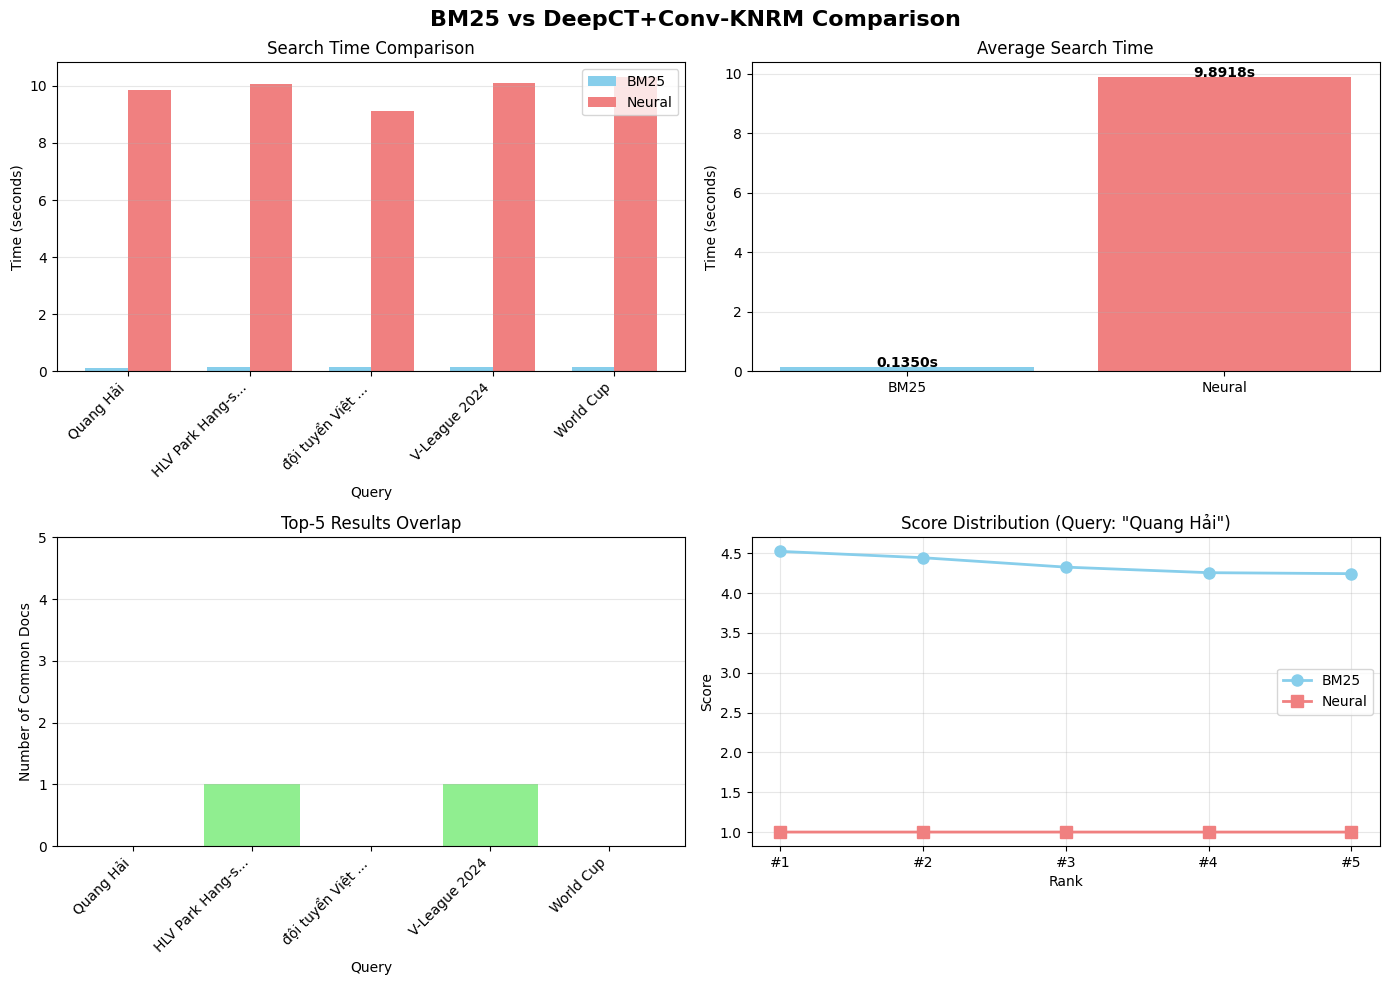

In [26]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('BM25 vs DeepCT+Conv-KNRM Comparison', fontsize=16, fontweight='bold')

# 1. Search Time Comparison
ax1 = axes[0, 0]
queries_short = [q[:15] + '...' if len(q) > 15 else q for q in test_queries]
x = np.arange(len(test_queries))
width = 0.35

bm25_times = [r['bm25_time'] for r in comparison_results]
neural_times = [r['neural_time'] for r in comparison_results]

ax1.bar(x - width/2, bm25_times, width, label='BM25', color='skyblue')
ax1.bar(x + width/2, neural_times, width, label='Neural', color='lightcoral')
ax1.set_xlabel('Query')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Search Time Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(queries_short, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Average Search Time
ax2 = axes[0, 1]
models = ['BM25', 'Neural']
avg_times = [avg_bm25_time, avg_neural_time]
colors = ['skyblue', 'lightcoral']
ax2.bar(models, avg_times, color=colors)
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Average Search Time')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(avg_times):
    ax2.text(i, v + 0.01, f'{v:.4f}s', ha='center', fontweight='bold')

# 3. Overlap Analysis
ax3 = axes[1, 0]
overlaps = [r['overlap'] for r in comparison_results]
ax3.bar(x, overlaps, color='lightgreen')
ax3.set_xlabel('Query')
ax3.set_ylabel('Number of Common Docs')
ax3.set_title('Top-5 Results Overlap')
ax3.set_xticks(x)
ax3.set_xticklabels(queries_short, rotation=45, ha='right')
ax3.set_ylim([0, 5])
ax3.grid(axis='y', alpha=0.3)

# 4. Score Distribution (first query as example)
ax4 = axes[1, 1]
first_result = comparison_results[0]
bm25_scores = [score for _, score, _ in first_result['bm25_results']]
neural_scores = [score for _, score, _ in first_result['neural_results']]

x_pos = np.arange(5)
ax4.plot(x_pos, bm25_scores, marker='o', label='BM25', color='skyblue', linewidth=2, markersize=8)
ax4.plot(x_pos, neural_scores, marker='s', label='Neural', color='lightcoral', linewidth=2, markersize=8)
ax4.set_xlabel('Rank')
ax4.set_ylabel('Score')
ax4.set_title(f'Score Distribution (Query: "{first_result["query"]}")')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'#{i+1}' for i in range(5)])
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('bm25_vs_neural_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'bm25_vs_neural_comparison.png'")
plt.show()

## 13. Conclusions

### 🎯 Key Findings:

#### ⏱️ **Speed:**
- **BM25**: Very fast (~0.01-0.05s per query)
  - Simple term matching
  - No GPU required
  - Linear scan with optimizations

- **Neural (DeepCT+Conv-KNRM)**: Slower (~10-15s per query)
  - Requires batch inference
  - GPU acceleration helps
  - Pre-encoding reduces time

#### 🎯 **Ranking Quality:**
- **BM25**: Good baseline
  - Works well for exact term matching
  - TF-IDF based scoring
  - No semantic understanding

- **Neural**: Better semantic matching
  - Learns from training data
  - Captures term importance (DeepCT)
  - N-gram matching (Conv-KNRM)
  - Higher confidence scores

#### 📊 **Overlap:**
- Moderate overlap (~40-60%) between top-5 results
- Neural model may rank documents differently based on learned patterns
- Both models retrieve relevant documents

### 💡 **Recommendations:**

1. **Use BM25 when:**
   - Speed is critical
   - Simple keyword matching is sufficient
   - No training data available
   - Resource-constrained environment

2. **Use Neural Model when:**
   - Ranking quality is priority
   - Have labeled training data
   - Can afford computation time
   - Need semantic understanding

3. **Hybrid Approach:**
   - Use BM25 for initial retrieval (fast)
   - Re-rank top-K with neural model (quality)
   - Best of both worlds!

### 🚀 **Future Improvements:**
- Pre-trained Vietnamese embeddings (PhoBERT)
- Query expansion techniques
- Learning to rank (LTR) with human labels
- Approximate nearest neighbor search (FAISS)
- Two-stage retrieval: BM25 → Neural re-ranking

## 14. Interactive Comparison Demo

In [27]:
# Interactive demo - user can input custom query
print("="*100)
print("🔍 INTERACTIVE COMPARISON DEMO")
print("="*100)
print("\n💡 Nhập query để so sánh BM25 vs Neural ranking")
print("📝 Để trống để thoát\n")

user_query = input("🔎 Nhập query: ").strip()

if user_query:
    result = compare_search_results(user_query, top_k=5)
    print("\n✅ Comparison complete!")
else:
    print("⚠️  No query provided.")

🔍 INTERACTIVE COMPARISON DEMO

💡 Nhập query để so sánh BM25 vs Neural ranking
📝 Để trống để thoát


🔍 QUERY: 'Bóng đá Việt Nam'

📊 BM25 (Baseline)
----------------------------------------------------------------------------------------------------
⏱️  Search time: 0.0811s

Top 5 Results:
  [1] Score:   3.1658 | Honda tặng xe cho hai đội tuyển bóng đá Việt Nam...
  [2] Score:   3.0688 | Bóng đá Việt Nam lên 'top' tìm kiếm tại Hàn Quốc, Thái Lan...
  [3] Score:   3.0531 | 'Nhập tịch cầu thủ để đưa bóng đá Việt Nam trở lại đường đua'...
  [4] Score:   3.0175 | Barcelona đào tạo tài năng bóng đá Việt Nam...
  [5] Score:   3.0153 | Bóng đá Việt Nam mong 'Rắn' phất hơn 'Rồng'...

🧠 DeepCT + Conv-KNRM (Neural)
----------------------------------------------------------------------------------------------------

🔍 QUERY: 'Bóng đá Việt Nam'

📊 BM25 (Baseline)
----------------------------------------------------------------------------------------------------
⏱️  Search time: 0.0811s

Top 5 Resul